In [1]:
import pandas as pd
import numpy as np
import itertools
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.factorplots import interaction_plot
from sklearn.linear_model import LinearRegression

# 通気層の放射熱伝達率の推定方法の検証
## 分析用データの読み込み

In [2]:
# CSVファイルを読み込む
df = pd.read_csv('wall_status_data_frame_detailed.csv', index_col=0)

# 温度差の列を追加
df["delta_theta_as_e-theta_r"] = df["theta_as_e"] - df["theta_r"]
df["delta_theta_sat-theta_r"] = df["theta_sat"] - df["theta_r"]


# 収束しなかった場合のデータを削除する
df = df.query("is_optimize_succeed == True")

# 分析用にメッセージ列を削除
df = df.drop(["is_optimize_succeed", "optimize_message"], axis=1)

# 1つでも欠損値NaNがある行を削除する
df = df[~np.isnan(df).any(axis=1)]

## 冬期条件、夏期条件の計算結果をそれぞれ抽出

In [3]:
# 冬期条件の計算結果を抽出
df_winter = df.query("theta_e <= 10.0 & theta_r == 20.0")
df_winter

,theta_e,theta_r,j_surf,a_surf,C_1,C_2,l_h,l_w,l_d,angle,...,theta_as_e,k_e,q_room_side,heat_balance_0,heat_balance_1,heat_balance_2,heat_balance_3,heat_balance_4,delta_theta_as_e-theta_r,delta_theta_sat-theta_r
0,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-4.623813,0.820794,-2.363617,0.000000e+00,2.220446e-15,-1.776357e-15,2.842171e-14,-2.220446e-16,-24.623813,-30.0
1,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-4.887580,0.829586,-2.409223,0.000000e+00,3.552714e-15,3.552714e-15,0.000000e+00,-4.440892e-16,-24.887580,-30.0
2,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-4.949801,0.831660,-2.426662,-2.842171e-14,3.552714e-15,-7.105427e-15,-2.842171e-14,-4.440892e-16,-24.949801,-30.0
3,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-9.856252,0.995208,-2.892881,2.842171e-14,8.881784e-15,0.000000e+00,0.000000e+00,0.000000e+00,-29.856252,-30.0
4,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,-9.814749,0.993825,-2.901498,-2.842171e-14,-3.552714e-15,-7.105427e-15,0.000000e+00,-8.881784e-16,-29.814749,-30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295240,10.0,20.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,24.918480,0.163949,11.551022,-4.547474e-13,-3.979039e-13,-1.136868e-13,0.000000e+00,-1.776357e-15,4.918480,30.0
295241,10.0,20.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,28.197296,0.273243,20.277198,4.547474e-13,0.000000e+00,1.136868e-13,-5.684342e-14,8.881784e-16,8.197296,30.0
295242,10.0,20.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,15.758518,-0.141383,-9.942546,-4.547474e-13,1.527667e-12,8.526513e-14,2.842171e-14,-1.776357e-15,-4.241482,30.0
295243,10.0,20.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,20.797442,0.026581,1.971000,4.547474e-13,-3.410605e-13,-5.684342e-14,0.000000e+00,8.881784e-16,0.797442,30.0


In [4]:
# 夏期条件の計算結果を抽出
df_summer = df.query("theta_e >= 25.0 & theta_r == 27.0")
df_summer

,theta_e,theta_r,j_surf,a_surf,C_1,C_2,l_h,l_w,l_d,angle,...,theta_as_e,k_e,q_room_side,heat_balance_0,heat_balance_1,heat_balance_2,heat_balance_3,heat_balance_4,delta_theta_as_e-theta_r,delta_theta_sat-theta_r
413343,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,25.356350,0.821825,-0.153308,0.000000e+00,-1.776357e-15,7.105427e-15,0.000000e+00,1.776357e-15,-1.643650,-2.0
413344,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,25.334142,0.832929,-0.160680,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.665858,-2.0
413345,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,25.333373,0.833313,-0.162148,0.000000e+00,-1.421085e-14,-2.842171e-14,0.000000e+00,0.000000e+00,-1.666627,-2.0
413346,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,25.011235,0.994383,-0.191482,0.000000e+00,1.421085e-14,0.000000e+00,-2.842171e-14,0.000000e+00,-1.988765,-2.0
413347,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,25.018480,0.990760,-0.192738,0.000000e+00,1.421085e-14,0.000000e+00,-2.842171e-14,3.552714e-15,-1.981520,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708583,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,50.470072,0.488960,56.325852,0.000000e+00,-4.547474e-13,-1.136868e-13,8.526513e-14,0.000000e+00,23.470072,48.0
708584,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,53.646967,0.555145,67.563938,-1.818989e-12,-2.842171e-13,-2.273737e-13,2.842171e-14,0.000000e+00,26.646967,48.0
708585,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,40.829960,0.288124,32.615303,-9.094947e-13,4.227729e-13,5.684342e-14,-2.842171e-14,-3.552714e-15,13.829960,48.0
708586,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,46.506060,0.406376,48.920559,-9.094947e-13,1.023182e-12,2.273737e-13,-8.526513e-14,7.105427e-15,19.506060,48.0


## 作図用の関数を定義
### 散布図（線形回帰式あり）を作図する関数

In [5]:
def setPltSingle(df:pd.DataFrame, fig_title:str, x_label:str, y_label:str, x_data_name:str, y_data_name:str,
                is_fit_intercept:bool):
    
    """
    グラフを描画する（2変数の散布図、線形回帰式あり）
    
    :param df: CSVファイルの全データ
    :param fig_title: グラフタイトル
    :param x_label: X軸のラベル
    :param y_label: Y軸のラベル
    :param x_data_name: X軸に設定するデータの名称
    :param y_data_name: Y軸に設定するデータの名称
    :return: なし
    """
        
    # グラフを表示する領域（figureオブジェクト）、グラフを描画する領域（Axesオブジェクト）を作成
    # グラフサイズを指定する　デフォルト：figsize=(6.4, 4.8)、小サイズ：figsize=(4.0, 3.5)
    fig, ax = plt.subplots(figsize=(3.7, 3.5))
    
    # フォントサイズを設定
    plt.rcParams["font.size"] = 14

    # グラフタイトルを設定
    fig.suptitle(fig_title)
    
    # 単回帰分析を行うsklearn.linear_model.LinearRegressionクラスを読み込み
    # fit_intercept:切片を求める計算をするか（True:切片を計算する、False:切片を計算しない）
    model_lr = LinearRegression(fit_intercept=is_fit_intercept)

    # 補助軸の設定
    ax.grid(which='major', color='gray', linestyle='-')
    ax.grid(which='minor', color='gray', linestyle='-')
    
    # 軸ラベルの設定
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    # 描画データ設定
    x = df[x_data_name].to_numpy().reshape(-1, 1)
    y = df[y_data_name].to_numpy().reshape(-1, 1)

    # 線形回帰モデルを作成
    model_lr.fit(x, y)
    a = model_lr.coef_[0][0]   # 回帰係数
    if is_fit_intercept == True:  # 切片 (誤差)
        b = model_lr.intercept_[0]
    else:
        b = model_lr.intercept_
    r2 = model_lr.score(x, y)  # 決定係数
    
    # 散布図の描画設定
    ax.scatter(x, y, s=30, marker=".")
        
    # 線形近似の描画設定
    ax.plot(x, model_lr.predict(x),color="black")

    # 近似式の表示（text関数の引数：x座標、y座標、表示するテキスト）
    ax.text(np.mean(x) - np.mean(x) * 0.3, np.mean(y) + np.mean(y) * 0.6, 'y='+ str(round(a, 3)) +'x+'+str(round(b,3)))
        
    # 決定係数の表示
    ax.text(np.mean(x) - np.mean(x) * 0.3, np.mean(y) + np.mean(y) * 0.9, 'R2='+ str(round(r2,4)))

    # グラフ描画
    plt.show()

### 推定値の確認用グラフを作図する関数

In [6]:
def setPltComparison(fig_title:str, x_label:str, y_label:str, x_data:pd.DataFrame, y_data:pd.DataFrame,
                     xlim_min:float, xlim_max:float, ylim_min:float, ylim_max:float):
    
    # グラフを表示する領域（figureオブジェクト）、グラフを描画する領域（Axesオブジェクト）を作成
    # グラフサイズを指定する　デフォルト：figsize=(6.4, 4.8)、小サイズ：figsize=(4.0, 3.5)
    fig, ax = plt.subplots(figsize=(3.7, 3.5))
    
    # フォントサイズを設定
    plt.rcParams["font.size"] = 14

    # グラフタイトルを設定
    fig.suptitle(fig_title)
        
    # 補助軸の設定
    ax.grid(which='major', color='gray', linestyle='-')
    ax.grid(which='minor', color='gray', linestyle='-')
        
    # 軸ラベルの設定
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
        
    # 描画データ設定
    x = x_data.to_numpy().reshape(-1, 1)
    y = y_data.to_numpy().reshape(-1, 1)
    
    # 単回帰分析を行うsklearn.linear_model.LinearRegressionクラスを読み込み
    model_lr = LinearRegression()
    
    # 線形回帰モデルを作成
    model_lr.fit(x, y)
    a = model_lr.coef_[0][0]   # 回帰係数
    b = model_lr.intercept_    # 切片 (誤差)
    r2 = model_lr.score(x, y)  # 決定係数
    
    # 散布図の描画設定
    ax.scatter(x, y, s=30, marker=".")

    # 線形グラフの描画設定    
    ax.plot([xlim_min, xlim_max], [ylim_min, ylim_max],color="black")
    
    # 線形近似の描画設定
    ax.plot(x, model_lr.predict(x), color="Magenta", linestyle="dashed")
        
    # 軸の描画範囲設定
    ax.set_xlim(xlim_min, xlim_max)
    ax.set_ylim(ylim_min, ylim_max)
    
    # グラフ描画
    plt.show()

## 放射熱伝達率の検証
### 重回帰分析：冬期条件

In [7]:
# 最小二乗法による回帰モデルを作成
formula_1 = "h_rv ~ theta_e + j_surf + a_surf + C_1 + C_2 + l_h + l_w + l_d + angle + v_a + emissivity_2"
model_winter = ols(formula_1, df_winter).fit()
model_winter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   h_rv   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                 5.326e+05
Date:                Wed, 12 May 2021   Prob (F-statistic):               0.00
Time:                        09:44:37   Log-Likelihood:                -2985.0
No. Observations:              157464   AIC:                             5994.
Df Residuals:                  157452   BIC:                             6114.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.1222      0.003    -43.173      0.000      -0.128      -0.117
theta_e          0.0205   7.39e-05    276.809      0.000       0.020       0.021
j_surf           0.0003   1.48e-06    169.345      0.000       0.000       0.000
a_surf           0.2504      0.001    169.345      0.000       0.248       0.253
C_1              0.0002   1.53e-05     11.642      0.000       0.000       0.000
C_2              0.0185      0.000     59.654      0.000       0.018       0.019
l_h              0.0021      0.000     12.503      0.000       0.002       0.002
l_w           8.755e-13      0.000   5.72e-09      1.000      -0.000       0.000
l_d             -0.0971      0.006    -15.939      0.000      -0.109      -0.085
angle         1.481e-05   1.69e-05      0.876      0.381   -1.83e-05     4.8e-05
v_a             -0.1901      0.002   -124.902      0.000      -0.193      -0.187
emissivity_2     4.5451      0.002   2388.544      0.000       4.541       4.549
==============================================================================
Omnibus:                    34081.142   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           132202.782
Skew:                           1.041   Prob(JB):                         0.00
Kurtosis:                       6.977   Cond. No.                     6.38e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 重回帰分析：夏期条件

In [8]:
# 最小二乗法による回帰モデルを作成
formula_1 = "h_rv ~ theta_e + j_surf + a_surf + C_1 + C_2 + l_h + l_w + l_d + angle + v_a + emissivity_2"
model_summer = ols(formula_1, df_summer).fit()
model_summer.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   h_rv   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                 9.331e+05
Date:                Wed, 12 May 2021   Prob (F-statistic):               0.00
Time:                        09:44:37   Log-Likelihood:                -10782.
No. Observations:              177147   AIC:                         2.159e+04
Df Residuals:                  177135   BIC:                         2.171e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.9482      0.005   -179.030      0.000      -0.959      -0.938
theta_e          0.0244      0.000    163.289      0.000       0.024       0.025
j_surf           0.0003    1.5e-06    204.314      0.000       0.000       0.000
a_surf           0.3058      0.001    204.314      0.000       0.303       0.309
C_1              0.0017    1.5e-05    111.707      0.000       0.002       0.002
C_2             -0.0159      0.000    -52.087      0.000      -0.017      -0.015
l_h              0.0014      0.000      8.550      0.000       0.001       0.002
l_w           3.401e-14      0.000   2.26e-10      1.000      -0.000       0.000
l_d             -0.0702      0.006    -11.731      0.000      -0.082      -0.058
angle         2.131e-06   1.66e-05      0.128      0.898   -3.05e-05    3.47e-05
v_a             -0.0919      0.001    -61.428      0.000      -0.095      -0.089
emissivity_2     5.9559      0.002   3183.596      0.000       5.952       5.960
==============================================================================
Omnibus:                    67758.628   Durbin-Watson:                   1.654
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           442468.764
Skew:                           1.702   Prob(JB):                         0.00
Kurtosis:                       9.954   Cond. No.                     6.66e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 散布図による検証
### 外気温度（theta_e）× 放射熱伝達率（h_rv）

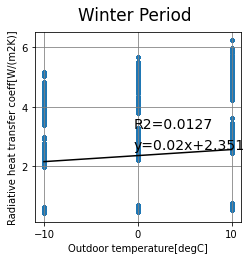

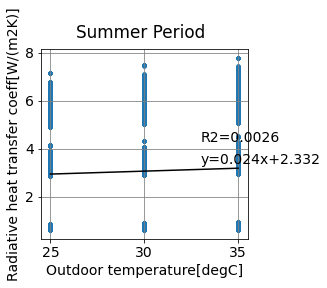

In [9]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Outdoor temperature[degC]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "theta_e",
       y_data_name = "h_rv",
       is_fit_intercept = True
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Outdoor temperature[degC]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "theta_e",
       y_data_name = "h_rv",
       is_fit_intercept = True
      )

### 外気側表面に入射する日射量（j_surf）× 放射熱伝達率（h_rv）

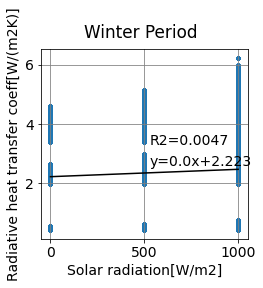

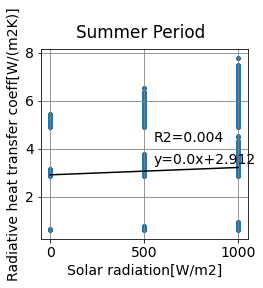

In [10]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Solar radiation[W/m2]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "j_surf",
       y_data_name = "h_rv",
       is_fit_intercept = True
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Solar radiation[W/m2]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "j_surf",
       y_data_name = "h_rv",
       is_fit_intercept = True
      )

### 外気側表面日射吸収率（a_surf）× 放射熱伝達率（h_rv）

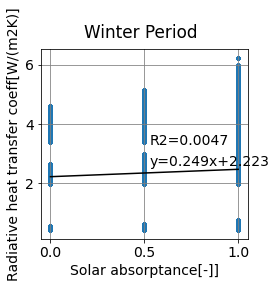

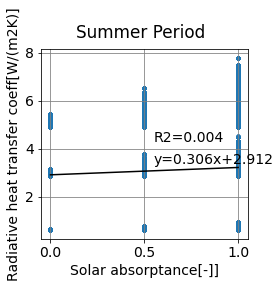

In [11]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Solar absorptance[-]]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "a_surf",
       y_data_name = "h_rv",
       is_fit_intercept = True
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Solar absorptance[-]]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "a_surf",
       y_data_name = "h_rv",
       is_fit_intercept = True
      )

### 外気側部材の熱コンダクタンス（C_1）× 放射熱伝達率（h_rv）

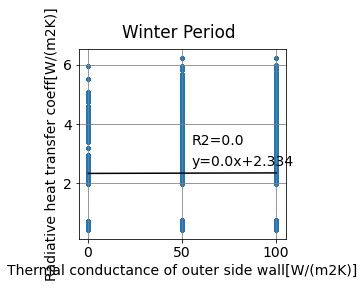

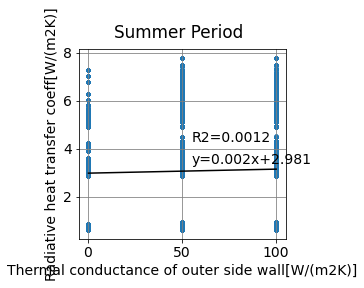

In [12]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Thermal conductance of outer side wall[W/(m2K)]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "C_1",
       y_data_name = "h_rv",
       is_fit_intercept = True
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Thermal conductance of outer side wall[W/(m2K)]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "C_1",
       y_data_name = "h_rv",
       is_fit_intercept = True
      )

### 室内側部材の熱コンダクタンス（C_2）× 放射熱伝達率（h_rv）

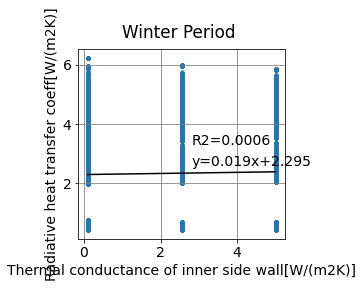

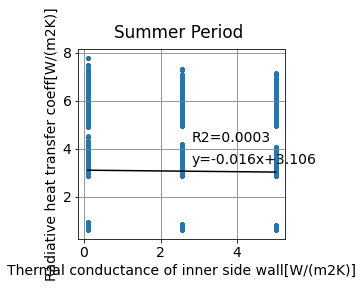

In [13]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Thermal conductance of inner side wall[W/(m2K)]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "C_2",
       y_data_name = "h_rv",
       is_fit_intercept = True
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Thermal conductance of inner side wall[W/(m2K)]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "C_2",
       y_data_name = "h_rv",
       is_fit_intercept = True
      )

### 通気層の長さ（l_h）× 放射熱伝達率（h_rv）

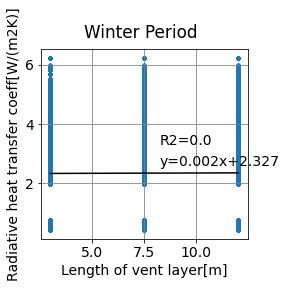

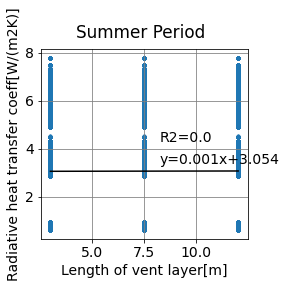

In [14]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Length of vent layer[m]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "l_h",
       y_data_name = "h_rv",
       is_fit_intercept = True
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Length of vent layer[m]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "l_h",
       y_data_name = "h_rv",
       is_fit_intercept = True
      )

### 通気層の厚さ（l_d）× 放射熱伝達率（h_rv）

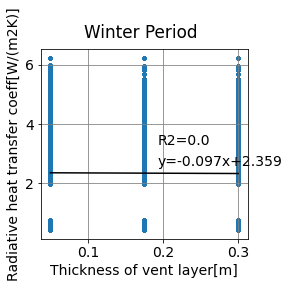

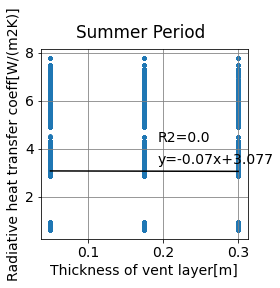

In [15]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Thickness of vent layer[m]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "l_d",
       y_data_name = "h_rv",
       is_fit_intercept = True
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Thickness of vent layer[m]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "l_d",
       y_data_name = "h_rv",
       is_fit_intercept = True
      )

### 通気層の傾斜角（angle）× 放射熱伝達率（h_rv）

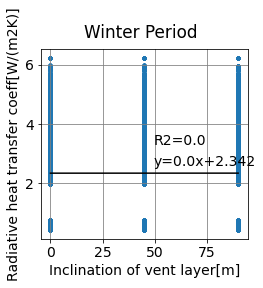

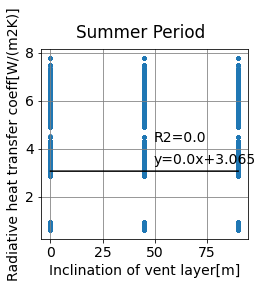

In [16]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Inclination of vent layer[m]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "angle",
       y_data_name = "h_rv",
       is_fit_intercept = True
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Inclination of vent layer[m]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "angle",
       y_data_name = "h_rv",
       is_fit_intercept = True
      )

### 通気層の平均風速（v_a）× 放射熱伝達率（h_rv）

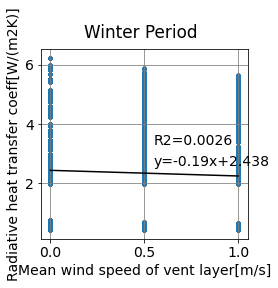

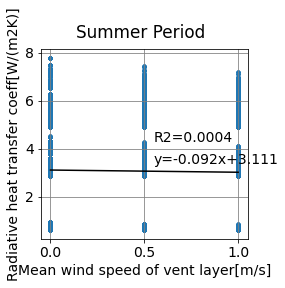

In [17]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Mean wind speed of vent layer[m/s]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "v_a",
       y_data_name = "h_rv",
       is_fit_intercept = True
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Mean wind speed of vent layer[m/s]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "v_a",
       y_data_name = "h_rv",
       is_fit_intercept = True
      )

### 通気層に面する面2の放射率（emissivity_2）× 放射熱伝達率（h_rv）

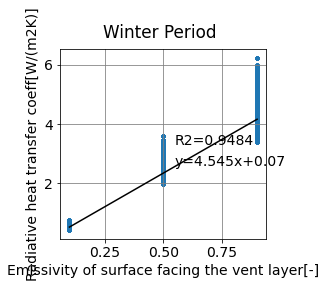

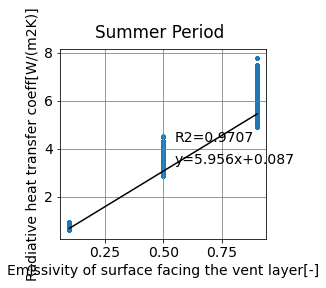

In [18]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Emissivity of surface facing the vent layer[-]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "emissivity_2",
       y_data_name = "h_rv",
       is_fit_intercept = True
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Emissivity of surface facing the vent layer[-]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "emissivity_2",
       y_data_name = "h_rv",
       is_fit_intercept = True
      )

### 通気層面の有効放射率（effective_emissivity）× 放射熱伝達率（h_rv）

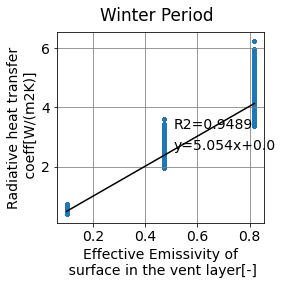

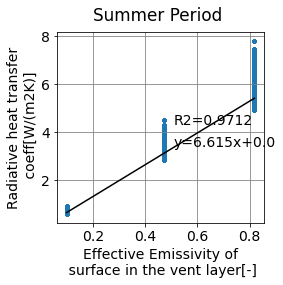

In [19]:
# 冬期条件
setPltSingle(df = df_winter,
       fig_title = "Winter Period",
       x_label = "Effective Emissivity of\n surface in the vent layer[-]",
       y_label = "Radiative heat transfer\n coeff[W/(m2K)]", 
       x_data_name = "effective_emissivity",
       y_data_name = "h_rv",
       is_fit_intercept = False
      )

# 夏期条件
setPltSingle(df = df_summer,
       fig_title = "Summer Period",
       x_label = "Effective Emissivity of\n surface in the vent layer[-]",
       y_label = "Radiative heat transfer\n coeff[W/(m2K)]", 
       x_data_name = "effective_emissivity",
       y_data_name = "h_rv",
       is_fit_intercept = False
      )

放射熱伝達率は、通気層面の有効放射率から推定できると仮定する。

### 冬期条件、夏期条件を統合した場合の放射熱伝達率の推定式を作成する

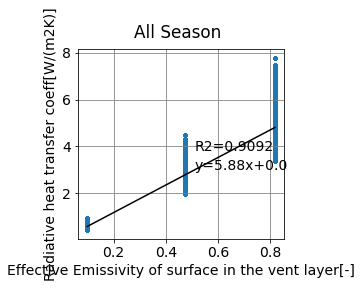

In [20]:
# 冬期条件、夏期条件のデータを統合
df_all = pd.concat([df_winter, df_summer])

# 散布図を作成
setPltSingle(df = df_all,
       fig_title = "All Season",
       x_label = "Effective Emissivity of surface in the vent layer[-]",
       y_label = "Radiative heat transfer coeff[W/(m2K)]", 
       x_data_name = "effective_emissivity",
       y_data_name = "h_rv",
       is_fit_intercept = False
      )

## 放射熱伝達率の推定結果の検証
### 冬期期間の回帰式による推定結果の検証
#### 推定結果の読み込み

In [21]:
# CSVファイルを読み込む
df_winter_simple = pd.read_csv('wall_status_data_frame_h_rv_simplified_winter.csv', index_col=0)

# 冬期条件の計算結果を抽出
df_winter_simple = df_winter_simple.query("theta_e <= 10.0 & theta_r == 20.0")

# 収束しなかった場合のデータを削除する
df_winter_simple = df_winter_simple.query("is_optimize_succeed == True")

# 分析用にメッセージ列を削除
df_winter_simple = df_winter_simple.drop(["is_optimize_succeed", "optimize_message"], axis=1)

# 1つでも欠損値NaNがある行を削除する
df_winter_simple = df_winter_simple[~np.isnan(df_winter_simple).any(axis=1)]
df_winter_simple

,theta_e,theta_r,j_surf,a_surf,C_1,C_2,l_h,l_w,l_d,angle,...,h_cv,h_rv,theta_as_e,k_e,q_room_side,heat_balance_0,heat_balance_1,heat_balance_2,heat_balance_3,heat_balance_4
0,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,2.807866,0.499846,-4.644496,0.821483,-2.366606,2.842171e-14,3.330669e-15,0.000000e+00,2.842171e-14,-2.220446e-16
1,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,2.439479,2.394000,-4.907001,0.830233,-2.413937,0.000000e+00,-3.552714e-15,-3.552714e-15,0.000000e+00,0.000000e+00
2,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,2.218813,4.135091,-4.960311,0.832010,-2.430766,-2.842171e-14,3.552714e-15,-7.105427e-15,-2.842171e-14,4.440892e-16
3,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,4.345775,0.499846,-9.854973,0.995166,-2.893629,-2.842171e-14,0.000000e+00,0.000000e+00,0.000000e+00,-8.881784e-16
4,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,4.051873,2.394000,-9.800897,0.993363,-2.902803,0.000000e+00,3.552714e-15,7.105427e-15,2.842171e-14,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295240,10.0,20.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,5.754232,2.394000,23.594610,0.119820,8.285620,0.000000e+00,6.181722e-13,2.842171e-14,0.000000e+00,3.552714e-15
295241,10.0,20.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,5.531100,4.135091,26.676971,0.222566,16.105988,4.547474e-13,-2.003731e-12,-5.684342e-14,2.842171e-14,1.065814e-14
295242,10.0,20.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,8.064079,0.499846,15.440133,-0.151996,-10.656882,4.547474e-13,-1.266542e-12,2.842171e-14,-5.684342e-14,3.552714e-15
295243,10.0,20.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,7.794280,2.394000,19.792048,-0.006932,-0.508112,-4.547474e-13,-4.902745e-13,0.000000e+00,0.000000e+00,5.329071e-15


#### 放射熱伝達率の計算結果比較（ 簡易計算と詳細計算の結果を比較）

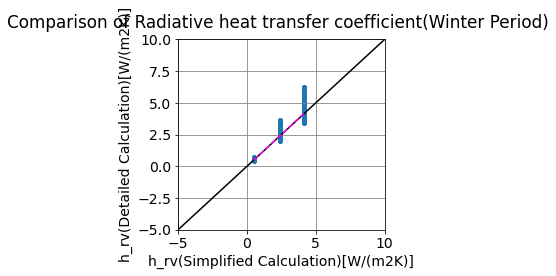

In [22]:
setPltComparison(
       fig_title = "Comparison of Radiative heat transfer coefficient(Winter Period)",
       x_label = "h_rv(Simplified Calculation)[W/(m2K)]",
       y_label = "h_rv(Detailed Calculation)[W/(m2K)]", 
       x_data = df_winter_simple["h_rv"],
       y_data = df_winter["h_rv"],
       xlim_min = -5.0,
       xlim_max = 10.0,
       ylim_min = -5.0,
       ylim_max = 10.0
      )

#### 相当熱貫流率の補正係数の計算結果比較（ 簡易計算と詳細計算の結果を比較）

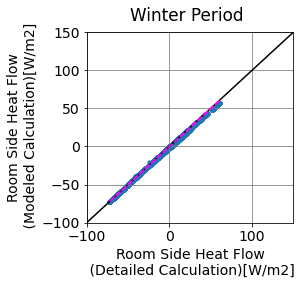

In [23]:
setPltComparison(
       #fig_title = "Comparison of Heat Flow(Winter Period)",
       #x_label = "q_room_side(Simplified Calculation)[-]",
       #y_label = "q_room_side(Detailed Calculation)[-]", 
       fig_title = "Winter Period",
       x_label = "Room Side Heat Flow\n (Detailed Calculation)[W/m2]",
       y_label = "Room Side Heat Flow\n (Modeled Calculation)[W/m2]",
       x_data = df_winter["q_room_side"],
       y_data = df_winter_simple["q_room_side"],
       xlim_min = -100.0,
       xlim_max = 150.0,
       ylim_min = -100.0,
       ylim_max = 150.0
      )

### 夏期期間の回帰式による推定結果の検証
#### 推定結果の読み込み

In [24]:
# CSVファイルを読み込む
df_summer_simple = pd.read_csv('wall_status_data_frame_h_rv_simplified_summer.csv', index_col=0)

# 冬期条件の計算結果を抽出
df_summer_simple = df_summer_simple.query("theta_e >= 25.0 & theta_r == 27.0")

# 収束しなかった場合のデータを削除する
df_summer_simple = df_summer_simple.query("is_optimize_succeed == True")

# 分析用にメッセージ列を削除
df_summer_simple = df_summer_simple.drop(["is_optimize_succeed", "optimize_message"], axis=1)

# 1つでも欠損値NaNがある行を削除する
df_summer_simple = df_summer_simple[~np.isnan(df_summer_simple).any(axis=1)]
df_summer_simple

,theta_e,theta_r,j_surf,a_surf,C_1,C_2,l_h,l_w,l_d,angle,...,h_cv,h_rv,theta_as_e,k_e,q_room_side,heat_balance_0,heat_balance_1,heat_balance_2,heat_balance_3,heat_balance_4
413343,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,1.042168,0.654231,25.354001,0.822999,-0.153823,0.000000e+00,0.000000e+00,7.105427e-15,0.000000e+00,-1.776357e-15
413344,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,1.042079,3.133421,25.333873,0.833063,-0.160969,0.000000e+00,0.000000e+00,-1.421085e-14,2.842171e-14,0.000000e+00
413345,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,1.042062,5.412273,25.333387,0.833307,-0.162342,0.000000e+00,2.842171e-14,2.842171e-14,0.000000e+00,0.000000e+00
413346,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,3.041124,0.654231,25.011412,0.994294,-0.191547,1.136868e-13,2.486900e-14,0.000000e+00,0.000000e+00,0.000000e+00
413347,25.0,27.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,3.041121,3.133421,25.019224,0.990388,-0.192813,0.000000e+00,1.421085e-14,-2.842171e-14,0.000000e+00,-3.552714e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708583,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,5.773845,3.133421,49.412892,0.466935,52.938127,-9.094947e-13,-3.467449e-12,1.136868e-13,5.684342e-14,1.065814e-14
708584,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,5.510994,5.412273,52.528288,0.531839,63.399302,-1.818989e-12,-1.080025e-12,1.136868e-13,0.000000e+00,7.105427e-15
708585,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,8.112067,0.654231,40.540945,0.282103,31.847234,9.094947e-13,1.705303e-13,0.000000e+00,0.000000e+00,-7.105427e-15
708586,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,7.775690,3.133421,45.679336,0.389153,46.376303,0.000000e+00,0.000000e+00,1.136868e-13,-2.842171e-14,0.000000e+00


#### 放射熱伝達率の計算結果比較（ 簡易計算と詳細計算の結果を比較）

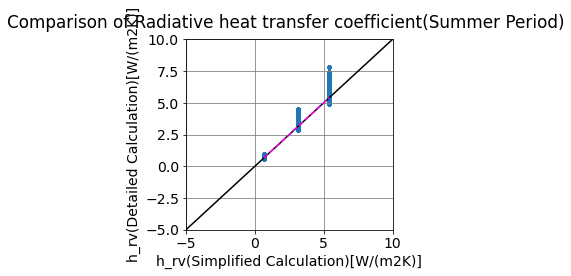

In [25]:
setPltComparison(
       fig_title = "Comparison of Radiative heat transfer coefficient(Summer Period)",
       x_label = "h_rv(Simplified Calculation)[W/(m2K)]",
       y_label = "h_rv(Detailed Calculation)[W/(m2K)]", 
       x_data = df_summer_simple["h_rv"],
       y_data = df_summer["h_rv"],
       xlim_min = -5.0,
       xlim_max = 10.0,
       ylim_min = -5.0,
       ylim_max = 10.0
      )

#### 相当熱貫流率の補正係数の計算結果比較（ 簡易計算と詳細計算の結果を比較）

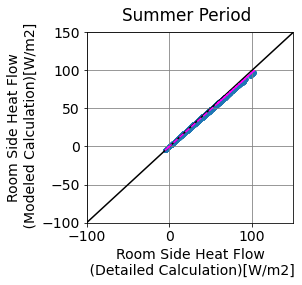

In [26]:
setPltComparison(
       #fig_title = "Comparison of Heat Flow(Summer Period)",
       #x_label = "q_room_side(Simplified Calculation)[-]",
       #y_label = "q_room_side(Detailed Calculation)[-]",
       fig_title = "Summer Period",
       x_label = "Room Side Heat Flow\n (Detailed Calculation)[W/m2]",
       y_label = "Room Side Heat Flow\n (Modeled Calculation)[W/m2]",
       x_data = df_summer["q_room_side"],
       y_data = df_summer_simple["q_room_side"],
       xlim_min = -100.0,
       xlim_max = 150.0,
       ylim_min = -100.0,
       ylim_max = 150.0
      )

### 通年の回帰式による推定結果の検証
#### 推定結果の読み込み

In [27]:
# CSVファイルを読み込む
df_all_simple = pd.read_csv('wall_status_data_frame_h_rv_simplified_all_season.csv', index_col=0)

# 冬期条件、夏期条件の計算結果を抽出
df_all_simple = pd.concat([df_all_simple.query("theta_e <= 10.0 & theta_r == 20.0"), df_all_simple.query("theta_e >= 25.0 & theta_r == 27.0")])

# 収束しなかった場合のデータを削除する
df_all_simple = df_all_simple.query("is_optimize_succeed == True")

# 分析用にメッセージ列を削除
df_all_simple = df_all_simple.drop(["is_optimize_succeed", "optimize_message"], axis=1)

# 1つでも欠損値NaNがある行を削除する
df_all_simple = df_all_simple[~np.isnan(df_all_simple).any(axis=1)]
df_all_simple

,theta_e,theta_r,j_surf,a_surf,C_1,C_2,l_h,l_w,l_d,angle,...,h_cv,h_rv,theta_as_e,k_e,q_room_side,heat_balance_0,heat_balance_1,heat_balance_2,heat_balance_3,heat_balance_4
0,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,2.786606,0.581538,-4.668441,0.822281,-2.370140,-5.684342e-14,4.440892e-16,1.776357e-15,0.000000e+00,-2.220446e-16
1,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,2.383787,2.785263,-4.925292,0.830843,-2.418858,-2.842171e-14,0.000000e+00,0.000000e+00,-2.842171e-14,0.000000e+00
2,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,2.147387,4.810909,-4.969043,0.832301,-2.434858,0.000000e+00,3.552714e-15,0.000000e+00,0.000000e+00,0.000000e+00
3,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,4.330557,0.581538,-9.853587,0.995120,-2.894279,0.000000e+00,0.000000e+00,0.000000e+00,-2.842171e-14,0.000000e+00
4,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,4.001627,2.785263,-9.788249,0.992942,-2.903776,0.000000e+00,0.000000e+00,-1.421085e-14,0.000000e+00,8.881784e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708583,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,5.820698,2.785263,48.768741,0.453515,50.943717,0.000000e+00,-7.105427e-13,-1.705303e-13,1.136868e-13,0.000000e+00
708584,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,5.573891,4.810909,51.854678,0.517806,61.007193,-9.094947e-13,-1.705303e-13,0.000000e+00,5.684342e-14,7.105427e-15
708585,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,8.123638,0.581538,40.338213,0.277879,31.311440,-9.094947e-13,1.705303e-13,5.684342e-14,-8.526513e-14,0.000000e+00
708586,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,7.817057,2.785263,45.121717,0.377536,44.697515,9.094947e-13,1.222134e-12,-5.684342e-14,0.000000e+00,0.000000e+00


#### 放射熱伝達率の計算結果比較（ 簡易計算と詳細計算の結果を比較）

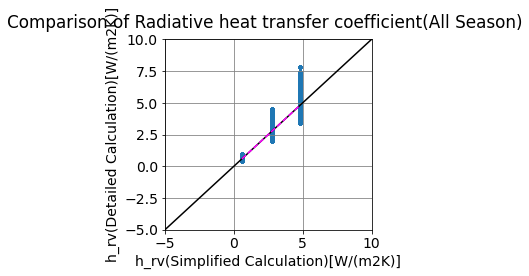

In [28]:
setPltComparison(
       fig_title = "Comparison of Radiative heat transfer coefficient(All Season)",
       x_label = "h_rv(Simplified Calculation)[W/(m2K)]",
       y_label = "h_rv(Detailed Calculation)[W/(m2K)]", 
       x_data = df_all_simple["h_rv"],
       y_data = df_all["h_rv"],
       xlim_min = -5.0,
       xlim_max = 10.0,
       ylim_min = -5.0,
       ylim_max = 10.0
      )

#### 相当熱貫流率の補正係数の計算結果比較（ 簡易計算と詳細計算の結果を比較）

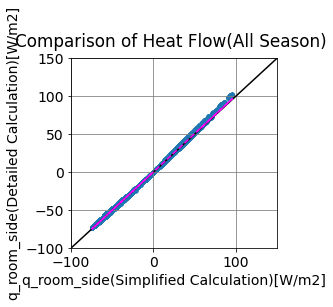

In [29]:
setPltComparison(
       fig_title = "Comparison of Heat Flow(All Season)",
       x_label = "q_room_side(Simplified Calculation)[W/m2]",
       y_label = "q_room_side(Detailed Calculation)[W/m2]", 
       x_data = df_all_simple["q_room_side"],
       y_data = df_all["q_room_side"],
       xlim_min = -100.0,
       xlim_max = 150.0,
       ylim_min = -100.0,
       ylim_max = 150.0
      )

### 放射熱伝達率をゼロとした場合の検証
#### 結果の読み込み

In [30]:
# CSVファイルを読み込む
df_h_rv_zero = pd.read_csv('wall_status_data_frame_h_rv_simplified_zero.csv', index_col=0)

# 冬期条件、夏期条件の計算結果を抽出
df_h_rv_zero = pd.concat([df_h_rv_zero.query("theta_e <= 10.0 & theta_r == 20.0"), df_h_rv_zero.query("theta_e >= 25.0 & theta_r == 27.0")])

# 収束しなかった場合のデータを削除する
df_h_rv_zero = df_h_rv_zero.query("is_optimize_succeed == True")

# 分析用にメッセージ列を削除
df_h_rv_zero = df_h_rv_zero.drop(["is_optimize_succeed", "optimize_message"], axis=1)

# 1つでも欠損値NaNがある行を削除する
df_h_rv_zero = df_h_rv_zero[~np.isnan(df_h_rv_zero).any(axis=1)]
df_h_rv_zero

,theta_e,theta_r,j_surf,a_surf,C_1,C_2,l_h,l_w,l_d,angle,...,h_cv,h_rv,theta_as_e,k_e,q_room_side,heat_balance_0,heat_balance_1,heat_balance_2,heat_balance_3,heat_balance_4
0,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,2.956526,0.0,-4.437997,0.814600,-2.338711,0.000000e+00,0.0,1.776357e-15,-2.842171e-14,-4.440892e-16
1,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,2.956526,0.0,-4.437997,0.814600,-2.338711,0.000000e+00,0.0,1.776357e-15,-2.842171e-14,-4.440892e-16
2,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,2.956526,0.0,-4.437997,0.814600,-2.338711,0.000000e+00,0.0,1.776357e-15,-2.842171e-14,-4.440892e-16
3,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,4.446844,0.0,-9.857957,0.995265,-2.888737,0.000000e+00,0.0,0.000000e+00,-2.842171e-14,8.881784e-16
4,-10.0,20.0,0.0,0.0,0.5,0.1,3.0,0.05,0.05,0.0,...,4.446844,0.0,-9.857957,0.995265,-2.888737,0.000000e+00,0.0,0.000000e+00,-2.842171e-14,8.881784e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708583,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,6.289706,0.0,40.514919,0.281561,28.748966,0.000000e+00,0.0,-1.136868e-13,5.684342e-14,-3.552714e-15
708584,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,6.289706,0.0,40.514919,0.281561,28.748966,0.000000e+00,0.0,-1.136868e-13,5.684342e-14,-3.552714e-15
708585,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,8.220552,0.0,38.566735,0.240974,26.727986,-9.094947e-13,0.0,-5.684342e-14,0.000000e+00,-3.552714e-15
708586,35.0,27.0,1000.0,1.0,100.0,5.0,12.0,10.00,0.30,90.0,...,8.220552,0.0,38.566735,0.240974,26.727986,-9.094947e-13,0.0,-5.684342e-14,0.000000e+00,-3.552714e-15


#### 放射熱伝達率の計算結果比較（ 簡易計算と詳細計算の結果を比較）

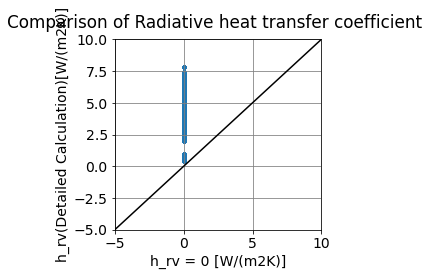

In [31]:
setPltComparison(
       fig_title = "Comparison of Radiative heat transfer coefficient",
       x_label = "h_rv = 0 [W/(m2K)]",
       y_label = "h_rv(Detailed Calculation)[W/(m2K)]", 
       x_data = df_h_rv_zero["h_rv"],
       y_data = df_all["h_rv"],
       xlim_min = -5.0,
       xlim_max = 10.0,
       ylim_min = -5.0,
       ylim_max = 10.0
      )

#### 相当熱貫流率の補正係数の計算結果比較（ 簡易計算と詳細計算の結果を比較）

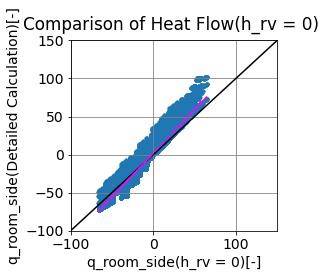

In [32]:
setPltComparison(
       fig_title = "Comparison of Heat Flow(h_rv = 0)",
       x_label = "q_room_side(h_rv = 0)[-]",
       y_label = "q_room_side(Detailed Calculation)[-]", 
       x_data = df_h_rv_zero["q_room_side"],
       y_data = df_all["q_room_side"],
       xlim_min = -100.0,
       xlim_max = 150.0,
       ylim_min = -100.0,
       ylim_max = 150.0
      )

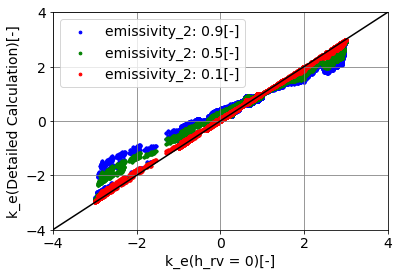

In [33]:
fig1 = plt.figure()
ax = fig1.add_subplot(1, 1, 1)

# 補助軸の設定
ax.grid(which='major', color='gray', linestyle='-')
ax.grid(which='minor', color='gray', linestyle='-')

# 軸ラベルの設定
ax.set_xlabel('k_e(h_rv = 0)[-]')
ax.set_ylabel('k_e(Detailed Calculation)[-]')

# 散布図の描画設定
ax.scatter(df_h_rv_zero.query("emissivity_2 == 0.9")['k_e'], df_all.query("emissivity_2 == 0.9")['k_e'], color='b', label='emissivity_2: 0.9[-]', s=30, marker=".")
ax.scatter(df_h_rv_zero.query("emissivity_2 == 0.5")['k_e'], df_all.query("emissivity_2 == 0.5")['k_e'], color='g', label='emissivity_2: 0.5[-]', s=30, marker=".")
ax.scatter(df_h_rv_zero.query("emissivity_2 == 0.1")['k_e'], df_all.query("emissivity_2 == 0.1")['k_e'], color='r', label='emissivity_2: 0.1[-]', s=30, marker=".")

# 線形グラフの描画設定    
ax.plot([-4.0, 4.0], [-4.0, 4.0],color="black")

# 軸の描画範囲設定
ax.set_xlim(-4.0, 4.0)
ax.set_ylim(-4.0, 4.0)
    
plt.legend()
plt.show()

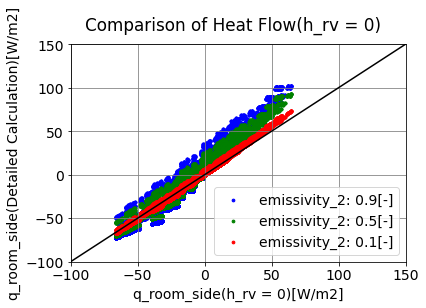

In [34]:
fig1 = plt.figure()
ax = fig1.add_subplot(1, 1, 1)

# グラフタイトルを設定
fig1.suptitle('Comparison of Heat Flow(h_rv = 0)')
    
# 補助軸の設定
ax.grid(which='major', color='gray', linestyle='-')
ax.grid(which='minor', color='gray', linestyle='-')

# 軸ラベルの設定
ax.set_xlabel('q_room_side(h_rv = 0)[W/m2]')
ax.set_ylabel('q_room_side(Detailed Calculation)[W/m2]')

# 散布図の描画設定
ax.scatter(df_h_rv_zero.query("emissivity_2 == 0.9")['q_room_side'], df_all.query("emissivity_2 == 0.9")['q_room_side'], color='b', label='emissivity_2: 0.9[-]', s=30, marker=".")
ax.scatter(df_h_rv_zero.query("emissivity_2 == 0.5")['q_room_side'], df_all.query("emissivity_2 == 0.5")['q_room_side'], color='g', label='emissivity_2: 0.5[-]', s=30, marker=".")
ax.scatter(df_h_rv_zero.query("emissivity_2 == 0.1")['q_room_side'], df_all.query("emissivity_2 == 0.1")['q_room_side'], color='r', label='emissivity_2: 0.1[-]', s=30, marker=".")

# 線形グラフの描画設定    
ax.plot([-100.0, 150.0], [-100.0, 150.0],color="black")

# 軸の描画範囲設定
ax.set_xlim(-100.0, 150.0)
ax.set_ylim(-100.0, 150.0)
    
plt.legend()
plt.show()